In [2]:
 import os
import numpy as np
import pandas as pd
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import IPython.display as ipd
import csv
import random
from sklearn.manifold import TSNE
from info_nce import InfoNCE, info_nce
from dataloader import DataLoader

In [3]:
train_input_data_path = '/Users/seoeunseo/Desktop/deep.daiv/Audio/프로젝트/train_folder/train_input_data.csv'
train_mel_spectrogram_path = '/Users/seoeunseo/Desktop/deep.daiv/Audio/프로젝트/train_folder/mel_spectrogram/'
test_input_data_path = '/Users/seoeunseo/Desktop/deep.daiv/Audio/프로젝트/train_folder/test_input_data 복사본.csv'
test_mel_spectrogram_path = '/Users/seoeunseo/Desktop/deep.daiv/Audio/프로젝트/music_mel/'
model_path = '/Users/seoeunseo/Desktop/deep.daiv/Audio/프로젝트/train_folder/please.pt'
optimizer_path = '/Users/seoeunseo/Desktop/deep.daiv/Audio/프로젝트/train_folder/optimizer_6_please.pt'

# 모델 선언

In [4]:
class Extract_Model(nn.Module):
    def __init__(self):
        super(Extract_Model, self).__init__()#input.shape == batch,128,157
        self.conv0 = nn.Conv2d(1, 256, kernel_size=5, padding=2, padding_mode='zeros', stride=1)
        self.conv1 = nn.Conv2d(256, 256, kernel_size=5, padding=2, padding_mode='zeros', stride=1)
        self.conv2 = nn.Conv2d(256, 256, kernel_size=5, padding=2, padding_mode='zeros', stride=1)
        self.conv3 = nn.Conv2d(256, 256, kernel_size=3, padding=1, padding_mode='zeros', stride=1)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1, padding_mode='zeros', stride=1)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, padding=1, padding_mode='zeros', stride=1)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1, padding_mode='zeros', stride=1)
        self.pool = nn.MaxPool2d(2)
        self.fc0 = nn.Linear(8*9*256, 512)
        self.fc1 = nn.Linear(512, 256)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = x.view(-1, 1, 128, 157)
        # x = (x/80)+1
        x = self.pool(self.relu(self.conv0(x)))#output.shape == 64,78
        y = x
        x = self.relu(self.conv1(x))#output.shape == 64,78
        x = self.relu(self.conv2(x))#output.shape == 64,78
        x = self.relu(self.conv3(x)+y)#output.shape == 64,78
        x = self.pool(self.relu(self.conv4(x)))#output.shape == 32,39
        x = self.pool(self.relu(self.conv5(x)))#output.shape == 16,19
        x = self.pool(self.relu(self.conv5(x)))#output.shape == 8,9
        x = torch.flatten(x,1)
        x = self.fc0(x)
        x = self.fc1(x)
        return x #output.shape == batch, 256

In [6]:
device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu')
# extract_model = Extract_Model().to(device)

In [7]:
extract_model = Extract_Model()
extract_model.load_state_dict(torch.load(model_path))
extract_model.to(device)

Extract_Model(
  (conv0): Conv2d(1, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv1): Conv2d(256, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(256, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc0): Linear(in_features=18432, out_features=512, bias=True)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=None)
)

In [8]:
optimizer = optim.Adam(extract_model.parameters(),lr=1e-6)

In [9]:
criterion = InfoNCE(negative_mode='paired')

# Test_show()

In [17]:
test_data = pd.read_csv('test_input_data 복사본.csv')
final_test_dataset = test_data.sort_values('name').reset_index().iloc[:,1:]
final_test_dataset= final_test_dataset.iloc[[0,10,20,30,40,50,60,70,80,90]].reset_index().iloc[:,1:]
test_artist_list = final_test_dataset['name'].unique().tolist()

In [16]:
# final_test_dataset= final_test_dataset[:100].reset_index().iloc[:,1:]
# test_artist_list = final_test_dataset['name'].unique().tolist()

In [77]:
# for i in range(11,100):
#         print(test_mel_spectrogram_path+ final_test_dataset['file'][i])
#         print(final_test_dataset['name'][i])

In [19]:
import platform        
from unicodedata import normalize
from dataloader import trim_mel

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus']= False

if platform.system() == 'Darwin': # 맥os 사용자의 경우에
    rc('font', family = 'AppleGothic')

elif platform.system() == 'Windows': # 윈도우 사용자의 경우에
    path = 'c:/Windows/Fonts/malgun.ttf'
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)

def test_show():   # 최종 테스트 셋 220개에 대해서 보여줌
    labels = []

    x = torch.tensor(trim_mel(np.load(test_mel_spectrogram_path+ final_test_dataset['file'][0])).reshape(1,128,157)).to(device)
    x = extract_model(x).cpu().detach().numpy()
    labels.append(final_test_dataset['name'][0])

    for j in range(9):
        song = np.load(test_mel_spectrogram_path+ final_test_dataset['file'][0])
        rd = random.randint(0,song.shape[1]-200)
        mel = torch.tensor(np.array(song[:,rd:rd+157]).reshape(1,128,157)).to(device)
        mel = extract_model(mel).cpu().detach().numpy()
        x = np.concatenate((x,mel),axis=0)
        labels.append(final_test_dataset['name'][0])


    for i in range(1,10):
        for j in range(10):
            song = np.load(test_mel_spectrogram_path+ final_test_dataset['file'][i])
            rd = random.randint(0,song.shape[1]-200)
            mel = torch.tensor(np.array(song[:,rd:rd+157]).reshape(1,128,157)).to(device)
            mel = extract_model(mel).cpu().detach().numpy()
            x = np.concatenate((x,mel),axis=0)
            labels.append(final_test_dataset['name'][0])


    tsne = TSNE(n_components=2, random_state=1,perplexity=40)
    X_tsne = tsne.fit_transform(x)

    sample_sizes = [10] * 10
    labels_uni = [] 
    for i in test_artist_list:
        labels_uni.append(normalize('NFC', i))

    y = np.array(labels_uni)
    singer_names = labels_uni

    plt.figure(figsize=(10, 8))
    for i in range(len(sample_sizes)): 
        plt.scatter(X_tsne[i * sample_sizes[i]:(i + 1) * sample_sizes[i], 0],
                    X_tsne[i * sample_sizes[i]:(i + 1) * sample_sizes[i], 1],label=singer_names[i])

    print('how many different voice :', np.unique(y).shape[0])
    plt.legend(labels=singer_names, loc='upper right')
    plt.show()

In [15]:
# import platform        
# from unicodedata import normalize
# from dataloader import trim_mel
# 
# from matplotlib import font_manager, rc
# plt.rcParams['axes.unicode_minus']= False
# 
# if platform.system() == 'Darwin': # 맥os 사용자의 경우에
#     rc('font', family = 'AppleGothic')
# 
# elif platform.system() == 'Windows': # 윈도우 사용자의 경우에
#     path = 'c:/Windows/Fonts/malgun.ttf'
#     font_name = font_manager.FontProperties(fname=path).get_name()
#     rc('font', family=font_name)
# 
# def test_show():   # 최종 테스트 셋 220개에 대해서 보여줌
#     labels = []
# 
#     x = torch.tensor(trim_mel(np.load(test_mel_spectrogram_path+ final_test_dataset['file'][0])).reshape(1,128,157)).to(device)
#     x = extract_model(x).cpu().detach().numpy()
#     labels.append(final_test_dataset['name'][0])
#     
#     for j in range(1,10):
#         song = np.load(test_mel_spectrogram_path+ final_test_dataset['file'][j])
#         rd = random.randint(0,song.shape[1]-200)
#         mel = torch.tensor(np.array(song[:,rd:rd+157]).reshape(1,128,157)).to(device)
#         mel = extract_model(mel).cpu().detach().numpy()
#         x = np.concatenate((x,mel),axis=0)
#         labels.append(final_test_dataset['name'][0])
#     
#     for i in range(11,100):
#         song = np.load(test_mel_spectrogram_path+ final_test_dataset['file'][i])
#         rd = random.randint(0,song.shape[1]-200)
#         mel = torch.tensor(np.array(song[:,rd:rd+157]).reshape(1,128,157)).to(device)
#         mel = extract_model(mel).cpu().detach().numpy()
#         x = np.concatenate((x,mel),axis=0)
#         labels.append(final_test_dataset['name'][i])
# 
#     
#     tsne = TSNE(n_components=2, random_state=1,perplexity=40)
#     X_tsne = tsne.fit_transform(x)
# 
#     sample_sizes = [10] * 10
#     labels_uni = [] 
#     for i in test_artist_list:
#         labels_uni.append(normalize('NFC', i))
#         
#     y = np.array(labels_uni)
#     singer_names = labels_uni
#     
#     plt.figure(figsize=(10, 8))
#     for i in range(len(sample_sizes)): 
#         plt.scatter(X_tsne[i * sample_sizes[i]:(i + 1) * sample_sizes[i], 0],
#                     X_tsne[i * sample_sizes[i]:(i + 1) * sample_sizes[i], 1],label=singer_names[i])
#     
#     print('how many different voice :', np.unique(y).shape[0])
#     plt.legend(labels=singer_names)
#     plt.show()

# 학습

In [10]:
# dataloader = DataLoader()
# for batch in dataloader.generate_batch()[:1]:
#     for sample in batch:
#         anc, pos, neg = sample[0], sample[1], sample[2:7]
#         print("Anchor:", anc)
#         print("Positive:", pos)
#         print("Negatives:", neg)
#         print(len(sample))
#     print(len(batch))


In [11]:
# np.array(batch)[:,0].shape # curr

In [12]:
# np.array(batch)[:,1].shape # pos

In [13]:
# np.array(batch)[:,2:].shape # neg

In [14]:
def train(batch):#배치로 넣음 (batch,7,128,157) anchor1 +1 -5
    output = [extract_model(batch[:,x]) for x in range(7)]

    query = output[0]
    positive_key = output[1]
    negative_keys = torch.stack(output[2:],dim=1)
    loss = criterion(query, positive_key, negative_keys)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss

# def test(batch):#배치로 넣음 (batch,7,128,157) anchor1 +1 -5
#     output = [extract_model(batch[:,x]) for x in range(7)]
# 
#     query = output[0]
#     positive_key = output[1]
#     negative_keys = torch.stack(output[2:],dim=1)
#     loss = criterion(query, positive_key, negative_keys)
#     optimizer.zero_grad()
# 
#     return loss

def evaluate(test_batch):
    extract_model.eval()
    
    with torch.no_grad():
        output = [extract_model(test_batch[:,x]) for x in range(7)]
        query = output[0]
        positive_key = output[1]
        negative_keys = torch.stack(output[2:],dim=1)
        loss = criterion(query, positive_key, negative_keys)
    
    return loss

In [ ]:
dataloader = DataLoader()
train_loss_visual = [2, 1.4, 1.3075682901786172, 1.2109897223224149]
test_loss_visual = [2, 1.75, 1.5586630759439766, 1.4235615837040232]
lowest_loss = 1.4235615837040232

 14%|█▎        | 100/737 [2:07:20<12:16:46, 69.40s/it]

loss : 1.360799114704132
test_loss : 1.6260857701301574
0.9386916984452919 epoch :  1
--------------------


 27%|██▋       | 200/737 [4:06:04<10:19:27, 69.21s/it]

loss : 1.3479672694206237
test_loss : 1.5902187359333038
1.8773833968905838 epoch :  1
--------------------


 41%|████      | 300/737 [6:00:40<8:18:11, 68.40s/it] 

loss : 1.3282548296451568
test_loss : 1.5770876729488372
2.8160750953358757 epoch :  1
--------------------


 54%|█████▍    | 400/737 [7:55:29<6:29:37, 69.37s/it]

loss : 1.3162273126840591
test_loss : 1.5356789636611938
3.7547667937811675 epoch :  1
--------------------


 68%|██████▊   | 500/737 [9:41:37<3:57:09, 60.04s/it]

loss : 1.2930724203586579
test_loss : 1.5622368371486663
4.693458492226459 epoch :  1
--------------------


 81%|████████▏ | 600/737 [11:26:06<2:29:30, 65.48s/it]

loss : 1.2553754401206971
test_loss : 1.5358047735691072
5.6321501906717515 epoch :  1
--------------------


 95%|█████████▍| 700/737 [13:08:37<36:57, 59.94s/it]  

loss : 1.2655980342626572
test_loss : 1.5043273210525512
6.570841889117043 epoch :  1
--------------------


100%|██████████| 737/737 [13:46:09<00:00, 67.26s/it]


how many different voice : 10


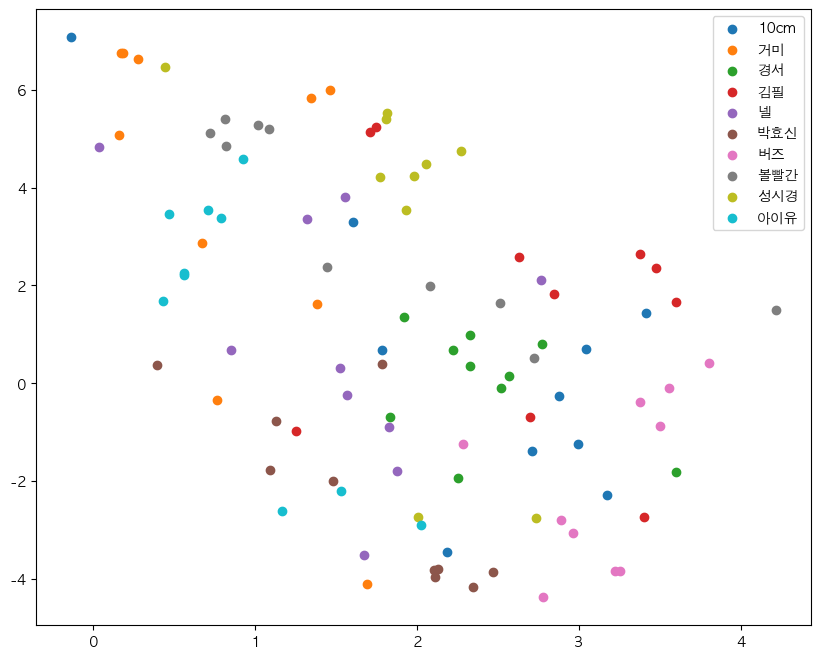

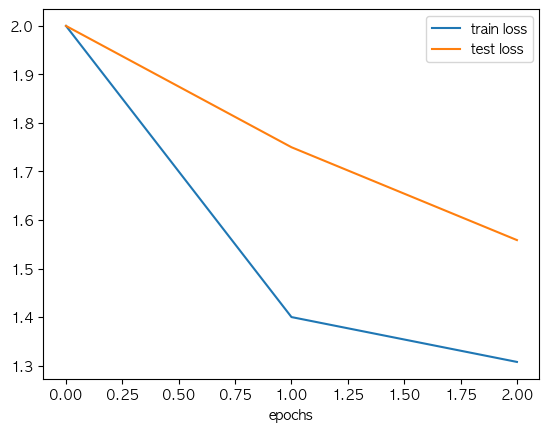

epoch_mean : 1.3075682901786172
test_epoch_mean : 1.5586630759439766
737


 14%|█▎        | 100/737 [1:38:52<10:31:29, 59.48s/it]

loss : 1.2604771518707276
test_loss : 1.4678789031505586
1.9386916984452918 epoch :  2
--------------------


 27%|██▋       | 200/737 [3:21:21<8:47:05, 58.89s/it] 

loss : 1.2254175072908402
test_loss : 1.4551646316051483
2.8773833968905835 epoch :  2
--------------------


 41%|████      | 300/737 [5:01:58<7:21:43, 60.65s/it]

loss : 1.196340560913086
test_loss : 1.44555837392807
3.8160750953358757 epoch :  2
--------------------


 54%|█████▍    | 400/737 [6:47:46<5:58:59, 63.91s/it]

loss : 1.2055092996358872
test_loss : 1.4066272759437561
4.754766793781167 epoch :  2
--------------------


 68%|██████▊   | 500/737 [8:30:41<4:04:06, 61.80s/it]

loss : 1.1846910655498504
test_loss : 1.4117039465904235
5.693458492226459 epoch :  2
--------------------


 81%|████████▏ | 600/737 [10:13:02<2:21:44, 62.08s/it]

loss : 1.2130485934019088
test_loss : 1.4042576742172241
6.6321501906717515 epoch :  2
--------------------


 95%|█████████▍| 700/737 [12:02:07<42:28, 68.88s/it]  

loss : 1.195592194199562
test_loss : 1.3893535101413728
7.570841889117043 epoch :  2
--------------------


100%|██████████| 737/737 [12:43:46<00:00, 62.18s/it]


how many different voice : 10


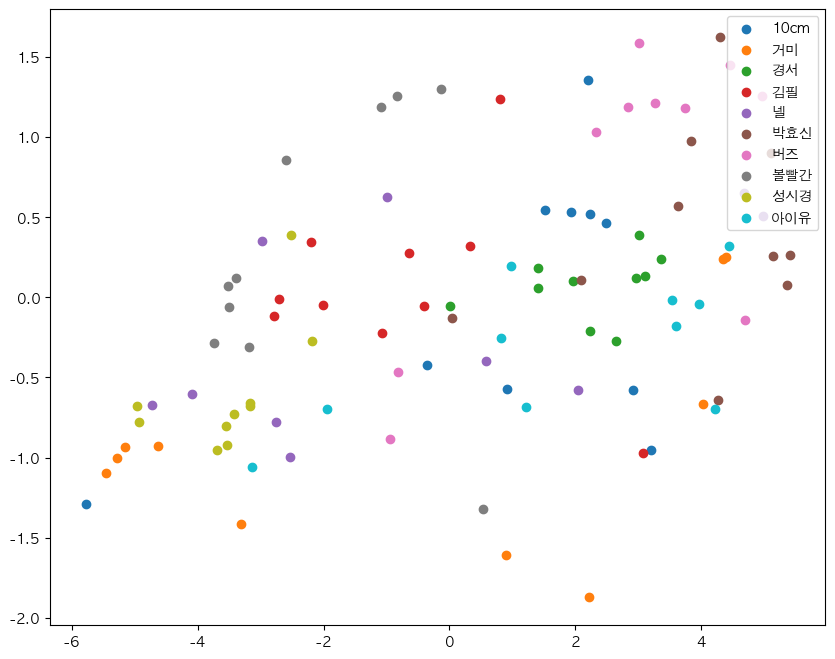

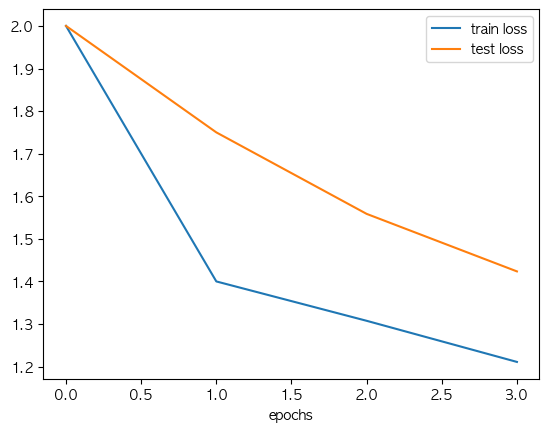

epoch_mean : 1.2109897223224149
test_epoch_mean : 1.4235615837040232
737


 14%|█▎        | 100/737 [1:57:36<12:10:36, 68.82s/it]

loss : 1.2055820220708846
test_loss : 1.3592760264873505
2.9386916984452918 epoch :  3
--------------------


 27%|██▋       | 200/737 [3:53:11<10:32:05, 70.62s/it]

loss : 1.1531950616836548
test_loss : 1.3268867057561875
3.8773833968905835 epoch :  3
--------------------


 41%|████      | 300/737 [5:40:00<7:42:48, 63.54s/it] 

loss : 1.1838636296987533
test_loss : 1.329964548945427
4.816075095335876 epoch :  3
--------------------


 46%|████▋     | 342/737 [6:26:27<7:26:21, 67.80s/it]


KeyboardInterrupt: 

In [22]:
epoch = 3

for i in range(epoch):
    mean_count = 0
    mini = 0
    
    loss_mean = 0
    loss_epoch_mean = 0
    
    test_loss_mean = 0
    test_loss_epoch_mean = 0
    
    batches = dataloader.generate_batch()
    
    for batch in tqdm(batches):
        mean_count = mean_count + 1
        
        train_loss = train(torch.tensor(np.array(batch)).to(device)).cpu().detach().numpy()    # 학습 loss
            
        test_batch = dataloader.generate_test_batch()
        # test_loss = test(torch.tensor(np.array(test_batch)).to(device)).cpu().detach().numpy() # 테스트 loss
        test_loss  = evaluate(torch.tensor(np.array(test_batch)).to(device)).cpu().detach().numpy()
        
        loss_mean += train_loss
        loss_epoch_mean += train_loss
        
        test_loss_mean += test_loss
        test_loss_epoch_mean += test_loss
        
        mini = mini + 1
        if(mini% 100 == 0):
            print('loss :',loss_mean/100)
            print('test_loss :',test_loss_mean/100)
            print(i+mini*32/3409,'epoch : ', i+1)
            print('--------------------')
            loss_mean = 0
            test_loss_mean = 0         
            
    test_show() 
    
    train_loss_visual.append(loss_epoch_mean/mean_count)
    test_loss_visual.append(test_loss_epoch_mean/mean_count)
    plt.plot(train_loss_visual,label='train loss')
    plt.plot(test_loss_visual,label='test loss')
    plt.xlabel('epochs')
    plt.legend()
    plt.show()
    print('epoch_mean :',loss_epoch_mean/mean_count)
    print('test_epoch_mean :',test_loss_epoch_mean/mean_count)
    print(mean_count)
    
    if test_loss_epoch_mean/mean_count < lowest_loss:
        lowest_loss = test_loss_epoch_mean/mean_count
        torch.save(extract_model.state_dict(), model_path)
        torch.save(optimizer.state_dict(), optimizer_path)

# Test SHow 불러오기

In [23]:
torch.save(extract_model.state_dict(), model_path)
torch.save(optimizer.state_dict(), optimizer_path)

In [27]:
extract_model = Extract_Model()
extract_model.load_state_dict(torch.load(model_path))
extract_model.to(device)

Extract_Model(
  (conv0): Conv2d(1, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv1): Conv2d(256, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(256, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc0): Linear(in_features=18432, out_features=512, bias=True)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=None)
)

In [28]:
optimizer.load_state_dict(torch.load(optimizer_path))

how many different voice : 10


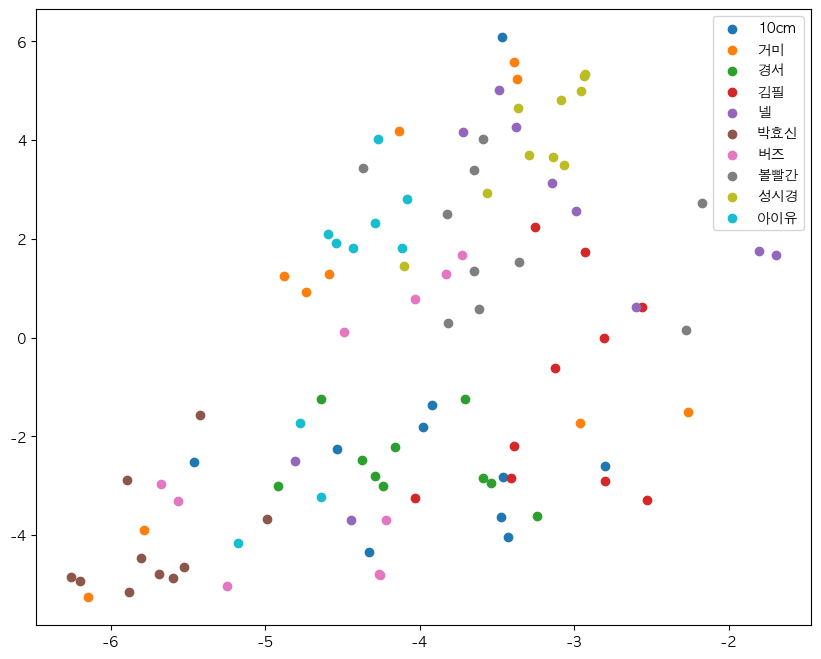

In [20]:
test_show()